# Sex Predictor EDA + Modelling
#### Arthur Castro Magno

The main objective of this jupyter notebook is to: 

1) Build a Jupyter Notebook used for "test_data_CANDIDATE.csv" exploratory data analysis.

2) Build a SEX PREDICTOR alongside with a script to apply the model to new data.

### Functions Definitions and Libraries Importing

In [36]:
#import all libraries that will be used

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [37]:
#Function Used to encoding [1]
def encode(target):
    return unique.tolist().index(target)

Data Import and Cleaning

In [38]:
#import data
missing_values = ["n/a","na","--", "NaN"] #list of possibles missing values
data_raw = pd.read_csv('test_data_CANDIDATE.csv', sep =',', na_values = missing_values)
data_raw.head(5) #checking the dataframe

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
0,0,49,M,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,1,61,F,10000,138,166.0,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,2,46,F,10000,140,311.0,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,3,69,F,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,4,51,F,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145


In [39]:
#Checking features data types:
data_raw.dtypes

index         int64
age           int64
sex          object
cp            int64
trestbps      int64
chol        float64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope       float64
ca            int64
thal          int64
nar           int64
hc            int64
sk            int64
trf         float64
dtype: object

In [40]:
#Checking missing values
print(data_raw.isna().sum()) #checking number of NA values left
data_raw.cp.unique()

index         0
age           0
sex           0
cp            0
trestbps      0
chol         16
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope       143
ca            0
thal          0
nar           0
hc            0
sk            0
trf           0
dtype: int64


array([10000], dtype=int64)

As we can see, we have NA values left in 'chol' and 'slope' features.
Before we do anything with them, let's check the features correlation.

Index(['index', 'age', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'nar', 'hc', 'sk', 'trf'],
      dtype='object')

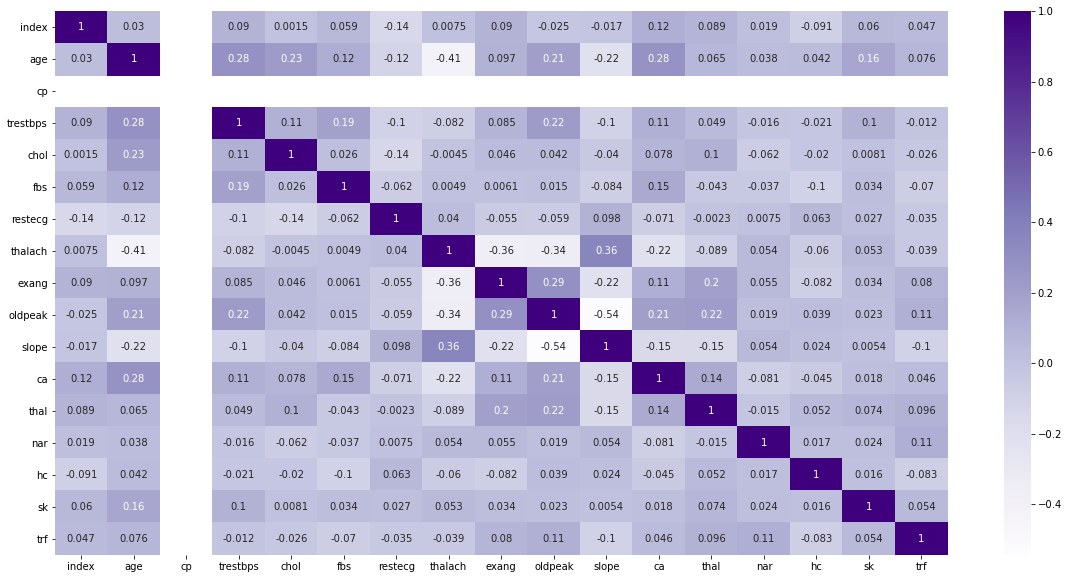

In [41]:
#Correlations Heatmap plot
corrmat = data_raw.corr() #get the correlation matrix
top_corr_features = corrmat.index #aux index to plot
plt.figure(figsize=(20,10))
#plot heat map
g=sns.heatmap(data_raw[top_corr_features].corr(),annot=True,cmap="Purples") #plot
top_corr_features

Although the high number of missing values, 'slope' has the highest correlation coefficient (with 'oldpeak'). Since the model has a small number of observations, it is better for us to keep that feature and fill the NA values with the median.

On the other hand, 'chol' have a few missing values but it doenst have a high degree of correlation with other features. However, we are still filling the 16 values left with the median.

In [42]:
data_fs = data_raw.copy()
median_s = data_fs['slope'].median()
median_c = data_fs['chol'].median()
#filling NA values
data_fs['slope'].fillna(median_s, inplace = True)
data_fs['chol'].fillna(median_c, inplace = True)
#Checking if there are still missing values
print('Missing Values left:\n', data_fs.isna().sum())

Missing Values left:
 index       0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
nar         0
hc          0
sk          0
trf         0
dtype: int64


In [43]:
data_fs = data_raw.copy()
median_s = data_fs['slope'].median() #storing slope median
median_c = data_fs['chol'].median() #storing chol median
#filling NA values
data_fs['slope'].fillna(median_s, inplace = True)
data_fs['chol'].fillna(median_c, inplace = True)
#Checking if there are still missing values
print('Missing Values left:\n', data_fs.isna().sum())



Missing Values left:
 index       0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
nar         0
hc          0
sk          0
trf         0
dtype: int64


From the correlation matrix above, we can infer that 'cp' feature has no variance between the observations. 
Following the principle of "garbage in, garbage out" we are also going to drop this collumn

In [44]:
data_fs = data_fs.drop(['index'], axis =1).copy() #droping index 
data_fs = data_fs.drop(['cp'], axis =1).copy() #droping cp
data_fs.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
0,49,M,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,61,F,138,166.0,0,0,125,1,3.6,1.0,1,2,2,1,3,4307.686943
2,46,F,140,311.0,0,1,120,1,1.8,1.0,2,3,2,0,1,4118.077502
3,69,F,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,51,F,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145


Before we make any exploratory data analysis (EDA), lets check the integrity of our target 'sex'.

Lets check if, as a string, it has some lower and upper case differentiations. Besides that, as it is an "object" data type, it is better for our algorithm to have the target values encoded aswell [function 1].

In [45]:
#Encoding
enco_data = data_fs.copy()
unique = enco_data['sex'].unique()
print("Target Labels:",sorted(unique))
enco_data['sex'] = enco_data.sex.str.upper()
enco_data['sex'] = enco_data['sex'].apply(encode)
print("Encoded Labels (Mirrored to target):",enco_data['sex'].unique().tolist())
enco_data.head()

Target Labels: ['F', 'M', 'f', 'm']
Encoded Labels (Mirrored to target): [0, 1]


,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
0,49,0,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,61,1,138,166.0,0,0,125,1,3.6,1.0,1,2,2,1,3,4307.686943
2,46,1,140,311.0,0,1,120,1,1.8,1.0,2,3,2,0,1,4118.077502
3,69,1,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,51,1,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145


So, now we have:

0 - Female

1 - Male

It's time for our EDA. Let's check the most high correlated features (age, oldpeak, slope, thalach, exang) and some others to check any insights or assumptions about the data.

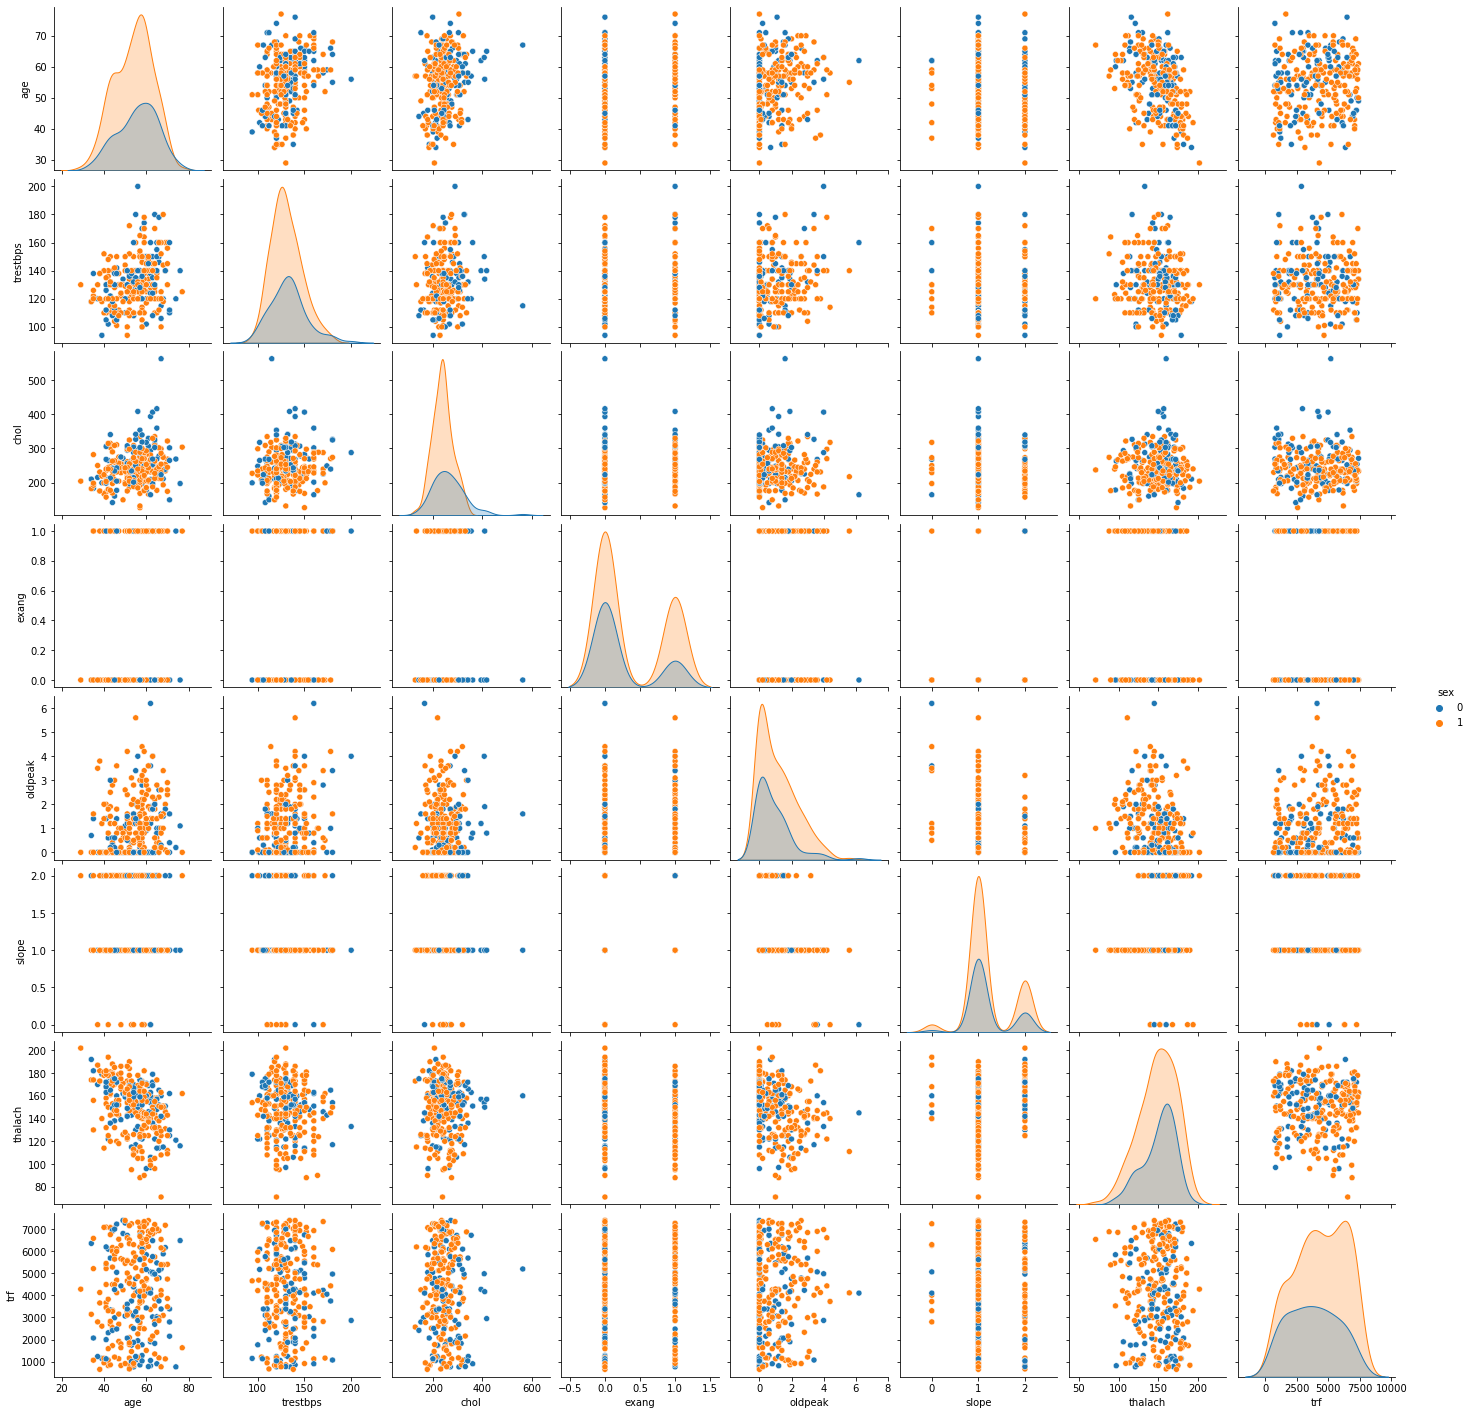

In [46]:
#Pairplot
eda = enco_data.copy()
eda = eda[['age','sex','trestbps','chol','exang','oldpeak','slope','thalach', 'trf']]
g = sns.pairplot(eda,hue='sex')
plt.show()

From the pairplot above, we can infer that the data is unbalanced, and that can impair the model learning performance.
We will count the 'sex' target variables to emphasize this point of view.

In [47]:
#Count of all labels

dfc= pd.DataFrame({"Label":np.unique(eda.sex),
                 "Count":np.asarray(np.unique(eda.sex, return_counts = True))[1,:]}) 
dfc


,Label,Count
0,0,92
1,1,196


Now we can see that we have more than twice as 'female' observations as 'male'.Before we do anything to solve this unbalance problem, let's take a further look into our data.

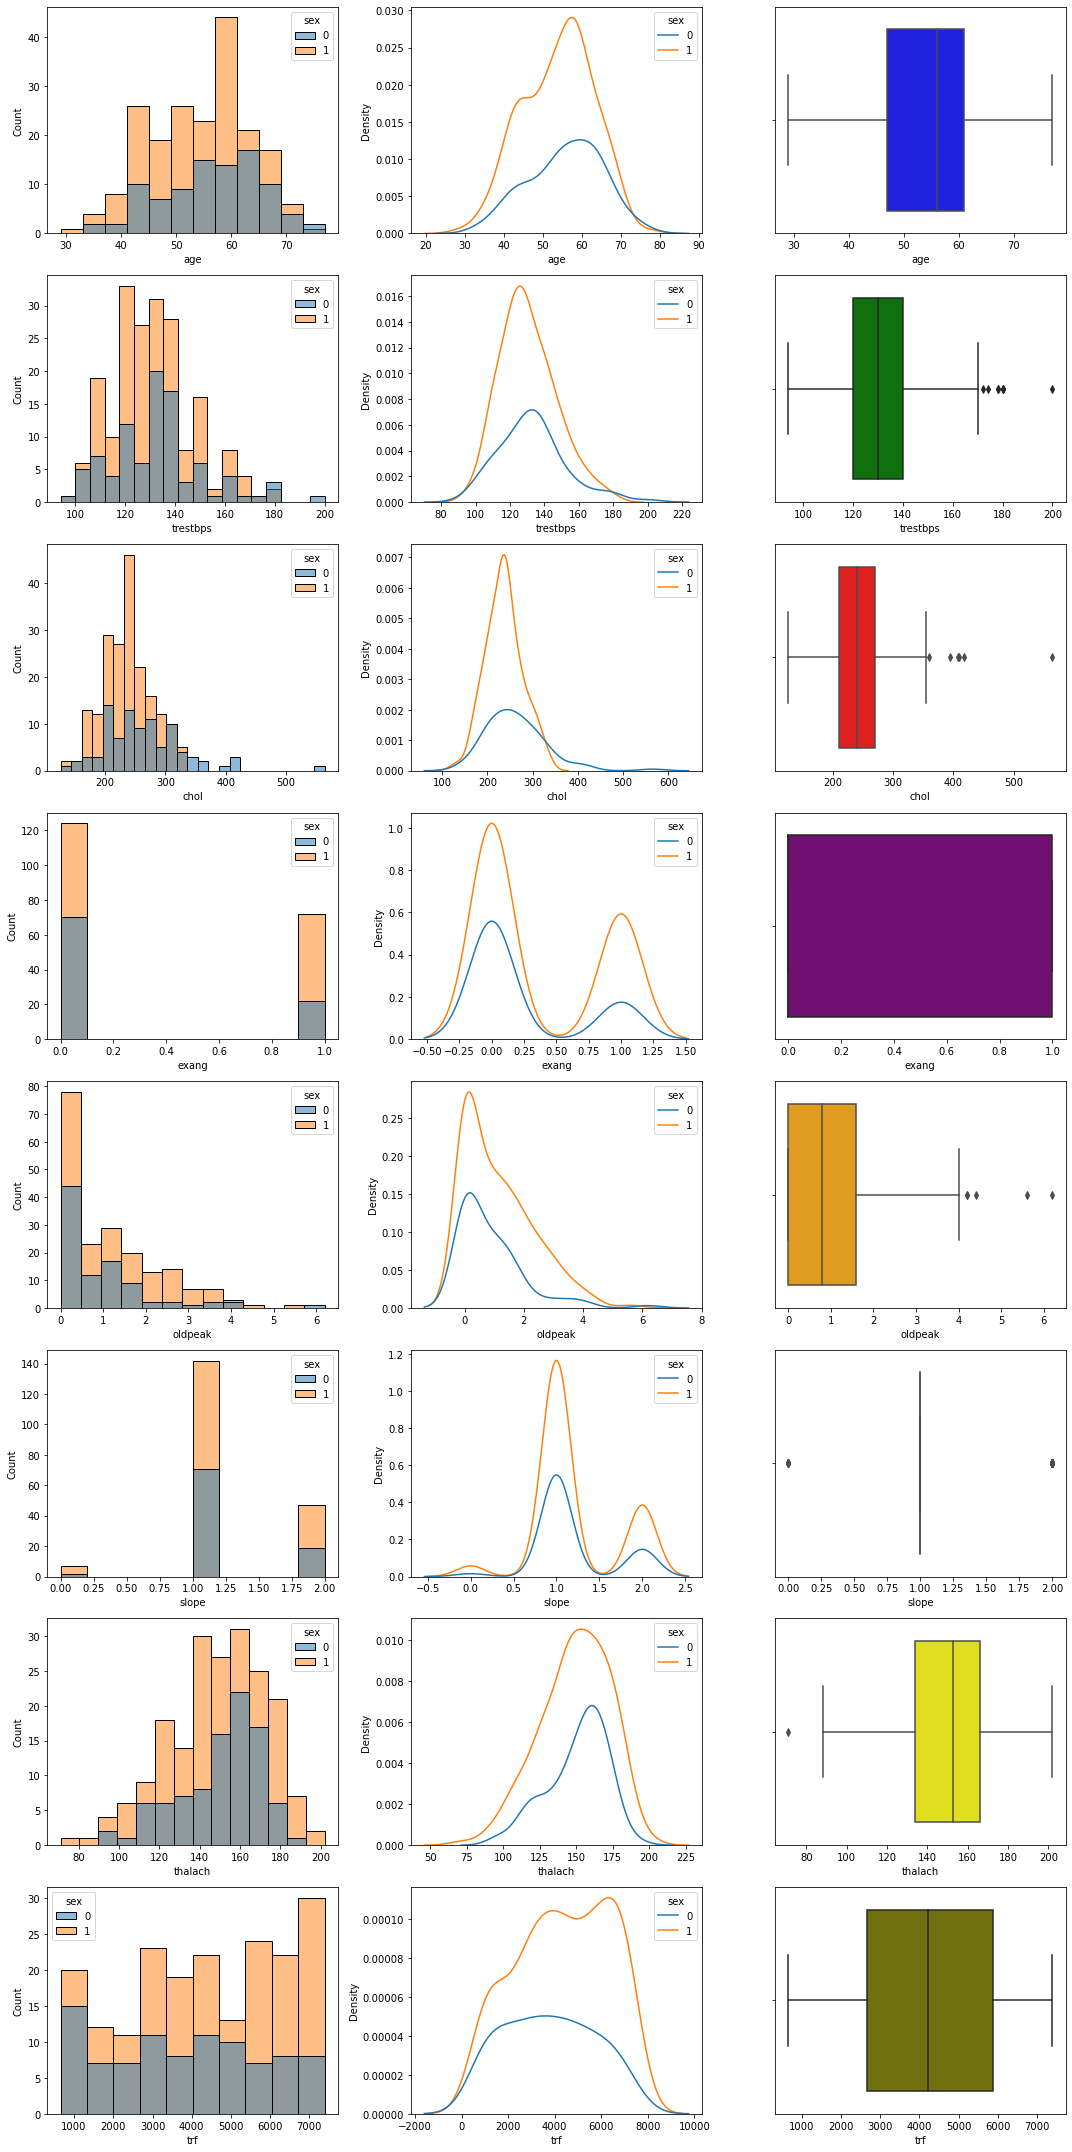

In [48]:
#General Attributes plot

figure, axes = plt.subplots(nrows=8, ncols=3, figsize=(15,30))
cols = ['age','trestbps','chol','exang','oldpeak', 'slope','thalach','trf'] #aux features variables to iterate through loop
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'yellow', 'olive'] #aux colors to make visualization clearer

for i in range(8):
    sns.histplot(x =eda[cols[i]], ax=axes[i, 0], color=colors[i],hue = eda['sex']) #Histogram
    sns.kdeplot(eda[cols[i]], ax=axes[i, 1], color=colors[i], hue = eda['sex']) #Density Plot
    sns.boxplot(x=cols[i], data=eda, ax=axes[i, 2], color=colors[i]) #Boxplot
    plt.tight_layout()

From the plot above, we can see that there are outliers points from feature 'trestbps', 'chol', 'oldpeak', and 'thalach'. That's another insight to make better use of data pre-processing and, hence, the model better. Let's check those features compared to the target variables to check on which targets the outliers are more prominent.

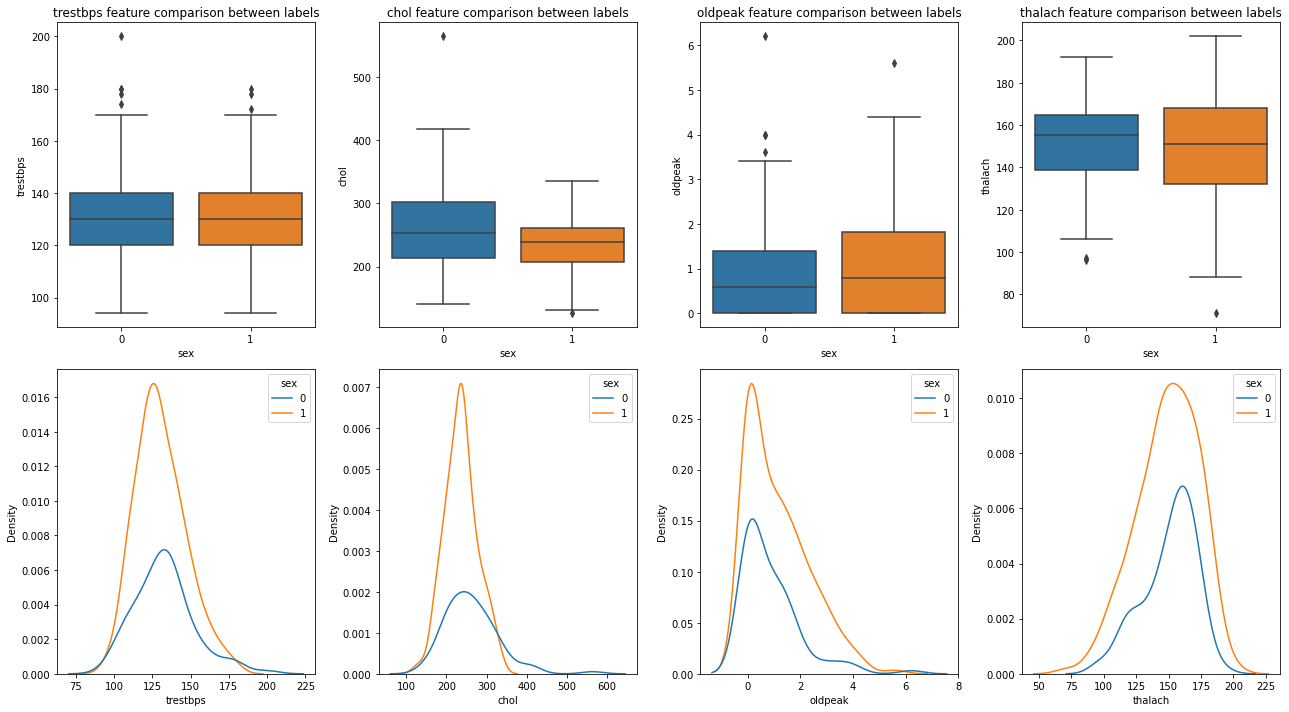

In [49]:
#Plot of features compared to target variable
figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,10))
cols = ['trestbps','chol','oldpeak','thalach']
for i in range(4):
    g1 = sns.boxplot(y=cols[i], x='sex', data=eda, ax=axes[0,i])
    g1.set_title(f"{cols[i]} feature comparison between labels")
    g2 = sns.kdeplot(x=cols[i], hue='sex', data=eda, ax=axes[1,i])
    plt.tight_layout()

Again, as we can see the outliers are most located on "Female" features. 

As we can see, there are no features strongly correlated with each other. As 'slope' has more than a half of missing values, we are considering the feature which are more correlated with each other. That is, "thalach", "oldpeak", "exang" and "age". Let's proceed to data preprocessing.

### Data Preprocessing and Model Preparation

As we previously saw, our data has some outliers. That is, it has points that have abnormal behaviors, so it can be just noise, not signal. Hence, let's remove all the outliers which z-score absolute value is smaller than 2.2.

In [137]:
#remove outliers
df = eda.copy() #copying data to keep data integrity
df = df[(np.abs(stats.zscore(df[['trestbps'] +['chol'] + ['oldpeak'] + ['thalach']]) < 2.2).all(axis=1))] #outlier removal
print('Outliers removed:', len(eda)-len(df))

Outliers removed: 25


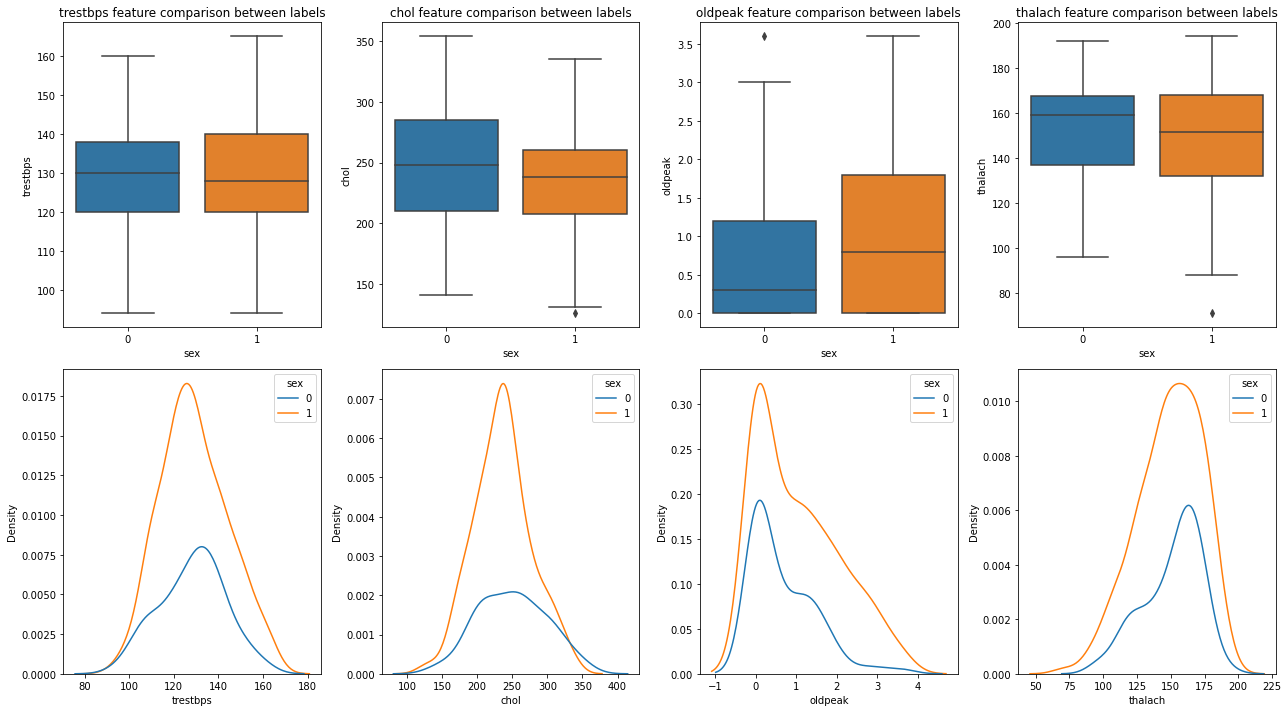

In [121]:
#Just looking at the data after outlier removal.
#Plot of features compared to target variable
figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,10))
cols = ['trestbps','chol','oldpeak','thalach']
for i in range(4):
    g1 = sns.boxplot(y=cols[i], x='sex', data=df, ax=axes[0,i])
    g1.set_title(f"{cols[i]} feature comparison between labels")
    g2 = sns.kdeplot(x=cols[i], hue='sex', data=df, ax=axes[1,i])
    plt.tight_layout()

Now that the outliers seem removed, let's procede with data balancing.
As we previously saw, we have more than twice female observations as male observations.
In order to balance the data, we will procede with the random oversampling technique of 'male' observations to improve balance and to reduce the model overfitting.

In [122]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
X = df.iloc[:, df.columns != 'sex']  #independent columns
y = df.iloc[:,1]    #target column i.e price range
#X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
#X_new.shape()
#X = df.iloc[:, df.columns != '']  #independent columns
#y = df.iloc[:,1]    #target column i.e price range
# class distribution
over = RandomOverSampler(sampling_strategy = 'minority')
# fit and apply the transform
X, y = over.fit_resample(X, y)
print('After random oversample: ',Counter(y))

After random oversample:  Counter({0: 184, 1: 184})


Last but not least, it is essential, as a final step of our preprocessing we need to split the data into train and test data.

To do it so, we will use 
- random_state=12 to ensure reproducible results
- train:test ratio = 80:20, to follow Pareto's Principle [https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d]
- shuffle = True, to avoid overfitting.

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=12, shuffle = True)

## Classifier Modeling

We are going to use supervised learning models to make our classifier. That is, we will use algorithms that considers both the features and the target variables to predict the output upon inputs. 

### 1 - K-Nearest Neighbors (KNN)

The K-Nearest Neighbors is a supervised learning algorithm evaluates the closeness between the label and its features from determined k-points, which are determined by the user.

#### Why use K-NN?

K-NN is one of the most simple machine learning models used nowadays. It is one of the best algorithms if we consider time to be more important than accuracy. In addition to that, it has only one hyperparameter to set, which makes model tuning much easier. Otherwise, if we need accuracy above all, there are other models that may be more suitable for our purposes. A con of this model is the high probability of overfitting occurence.

Firstly, lets check our optimum K.

Minimum error: 0.20270270270270271 at K = 0


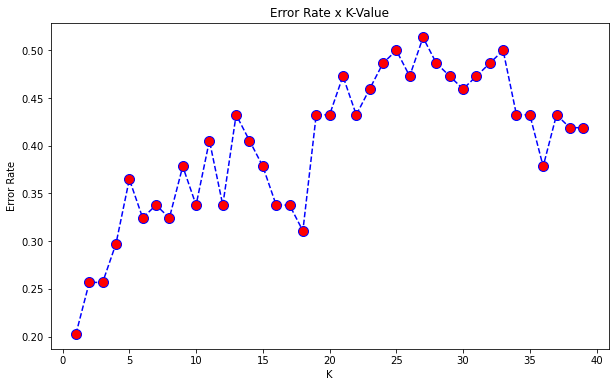

In [124]:
error_rate = [] #empty list to be iterated
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))#error rate list to be plotted

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate x K-Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:",min(error_rate),"at K =",error_rate.index(min(error_rate)))

If we increase the K we have more variance but less bias. On the other hand, if we decrease the K, we will have less variance, but it will increase the bias, increasing the probability of overfitting. Knowing that, let's use a K=2 to make precision a bit higher.

In [125]:
#Building our model with 2 neighbors and euclidian metrics
knn = KNeighborsClassifier(n_neighbors=2, metric='euclidean')
#Knn training
knn.fit(X_train, y_train)
#Class prediction upon the test dataset
y_pred_knn = knn.predict(X_test)
#Simple model F1-Score test (According to sklearn docs, f1 score can be interpreted as a weighted average of the precision
#and recall, where a F1 score reaches its best value at 1 and worst score at 0.)
print('The simple K-NN model F1-Score is ' + str(np.round(f1_score(y_test, y_pred_knn, average = 'macro'), 4)*100) + ' %.')

The simple K-NN model F1-Score is 70.38 %.


To check whether the model split was overfitted, we will procede with cross-validation to check out the model quality.

In [126]:
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=2, metric = 'euclidean')
#train model with crossvalidation of 10 fold
cv_scores = cross_val_score(knn_cv, X, y, cv=10, scoring = 'f1_macro')
#print each cv f1-score and their mean
print(cv_scores)

print('\nK-nn F1-Score Mean: ',np.round(np.mean(cv_scores)*100,2),'%')

[0.75018755 0.7797619  0.63141762 0.72470238 0.71273292 0.60734694
 0.56833333 0.74482759 0.66297872 0.797915  ]

K-nn F1-Score Mean:  69.8 %


After crossvalidation we checked the model variation quality, and it's F1-Score were about 1% lower. In addition to that, as we can see, our F1-Score took an acceptable result, and the time of execution was extremely fast, showing the main pros and cons of K-NN usage. On the other hand, the crossvalidation shows that the model was a little overfitted, due to the low amount of data.

## 2 - Random Forest Classifier (RF)

Random forests are another supervised learning algorithm, which builds an ensemble of decision trees (another supervised learning algorithm), which increases the prediction result overall.

#### Why use RF?

The RF models can achieve great results in terms of precision. It's default hyperparameters can produce a good result and the model can avoid overfitting on an easy manner. On the other hand, the trees development can be very slow, which make them not a great algorithm if we need very fast predictions.

In [127]:
#Building our random forest classifier
classifier =RandomForestClassifier(random_state=12) #random_state = 12 to ensure reproducibility
classifier.fit(X_train, y_train)
y_pred_rf = classifier.predict(X_test)
print('The Random Forest model F1-Score is ' + str(np.round(f1_score(y_test, y_pred_rf, average = 'macro'), 4)*100) + ' %.')

The Random Forest model F1-Score is 84.09 %.


In [128]:
#Building our random forest classifier

cv_scores2 = cross_val_score(classifier, X, y, cv=10, scoring = 'f1_macro')
print(cv_scores2)
print('\nRandom Forest Classifier F1-Score Mean: ',np.round(np.mean(cv_scores2)*100,2),'%')

[0.8377193  0.7018315  0.86486486 0.78362573 0.89117647 0.89117647
 0.97297297 0.86326681 0.91608392 0.91608392]

Random Forest Classifier F1-Score Mean:  86.39 %


As we had a better accuracy for this task, we are going to use and store the random forest model

In [33]:
import pickle
#Saving the model
pickle.dump(classifier, open("rf_model.pkl", 'wb'))

## Conclusion

As we can see, the random forest classifier performed better in terms of the F-score when compared to the k-NN, achieving a good prediction result, which implies that the Random forest is preferred if we want precision power. On the other hand, k-NN is very simple to use and it is fast to predict (it was about 9 times faster than Random Forest Classifier). Despite having less accuracy power, if speed is needed it would be the right choice. Hence, it all depends on 2 things:
- what kind of model bias do we want: More specifity? More sensitivity? 
- what factors we consider important 

Answering those two questions, we have a model more close to the state-of-art for our purposes

### Further Improvements

Let's check the confusion matrix to see some insights for the model improvement

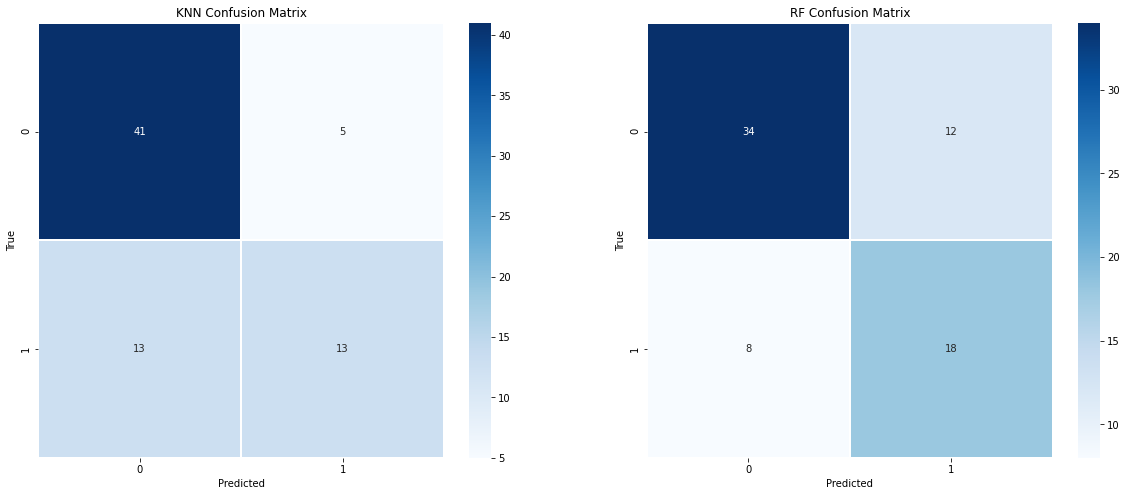

In [34]:
#Confusion Matrix

#Knn Confusion Matrix
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
ax1, ax2 = axes
cf_matrix_knn = pd.crosstab(y_test,y_pred_knn)
sns.heatmap(cf_matrix_knn, linewidths=1, annot=True, ax=ax1, fmt='g', cmap = 'Blues')
ax1.set_title("KNN Confusion Matrix", y=-0.1)
ax1.set_ylabel('True')
ax1.set_xlabel('Predicted')

#RF Confusion Matrix
cf_matrix_knn = pd.crosstab(y_test,y_pred_rf)
ax2.set_title("RF Confusion Matrix", y=-0.1)
sns.heatmap(cf_matrix_knn, linewidths=1, annot=True, ax=ax2, fmt='g', cmap = 'Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

As we can see on the Confusion Matrix of both models, the RF model have a good percentage of True Positives in both "Female" and "Male" predictions. On the other hand, KNN model was biased onto the prediction of "Female" Label. While it had a poorer accuracy performance, KNN would be more suitable if the model is suposed to be biased. If we want prediction power, RF is the preffered one.

For further improvements on this model accuracy, a good way to manage this problem is to add more data. In addition to that, we can improve the quality of our Random Forest Classifier by tuning hyperparameters. To perform that improvements, there is a lot of literature being released and kaggle.com provides a great opportunity of knowledge sharing. Hence, Machine Learning is a Science of improvements, so we need to be always able to keep improving our predictor.

